# DPM 2 - Variational Inference for Deep Continuous LVMs

**Filled notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/DL2/deep_probabilistic_models_II/tutorial_2b.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/DL2/deep_probabilistic_models_II/tutorial_2b.ipynb)  
**Authors**: Wilker Aziz 

## 0. Intended Learning Outcomes

After this tutorial the student should be able to

* parameterise a latent variable model with continuous latent variables
* estimate parameters using neural variational inference


**Remark** This tutorial builds upon the previous one and there is a lot of shared/unchanged code. The only changes are:

* additional prior nets (for continuous variables)
* additional CPD nets (for continuous variables)
* we changed DRL and forward in the NVIL class such that it can support LVMs trained via SFE or via reparameterisation

In [1]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as td

from functools import partial
from itertools import chain
from collections import defaultdict, OrderedDict
from tqdm.auto import tqdm

In [2]:
def seed_all(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

seed_all()

## 1. Data

We are going to use toy image datsets for this notebook. These are fixed-dimensional observations for which encoder and decoders are relatively easy to design. This way we can focus on the aspects that are probabilistic in nature.

In [3]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import random_split, Dataset
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.optim as opt

%matplotlib inline

A helper to binarize datasets:

In [4]:
class Binarizer(Dataset):

    def __init__(self, ds, threshold=0.5):
        self._ds = ds
        self._threshold = threshold

    def __len__(self):
        """Size of the corpus in number of sequence pairs"""
        return len(self._ds)

    def __getitem__(self, idx):
        """
        Return corpus_x[idx] and corpus_y[idx] converted to codes
        the latter has the EOS code in the end
        """
        x, y = self._ds[idx]
        return (x >= self._threshold).float(), y

FashionMNIST

In [5]:
dataset = FashionMNIST(root='data/', train=True, download=True, 
               transform=transforms.Compose([transforms.Resize(64), transforms.ToTensor()]))

In [6]:
img_shape = dataset[0][0].shape
print("Shape of an image:", img_shape)

Shape of an image: torch.Size([1, 64, 64])


Let's make a dev set for ourselves:

In [7]:
val_size = 1000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(59000, 1000)

we suggest that you binarize the data in a first pass through this notebook, but as you will see, we can also model the continuous pixel intensities.

In [8]:
bin_data = True

In [9]:
if bin_data:
    train_ds = Binarizer(train_ds)
    val_ds = Binarizer(val_ds)

In [10]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)

Let's visualise a few samples

images.shape: torch.Size([64, 1, 64, 64])


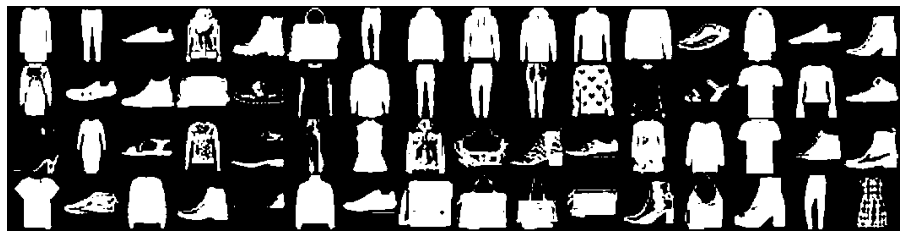

In [11]:
for images, y in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')    
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))    
    plt.show()
    break

## 2. Latent variable models

We will be using NNs to parameterise a latent variable model, that is, a joint distribution over a collection of random variables (rvs), some of which are observed, some of which are not.

We are interested in two random variables (rvs): 

* a discrete latent code $Z \in \mathcal Z$
* and an image $X \in \mathcal X \subseteq \mathbb R^D$

In this tutorial, $x$ is has a number $C$ of channels, a certain width $W$ and a certain height $H$, so $\mathcal X \subseteq \mathbb R^{C \times W \times H}$. Because we have fixed $D = C \times W \times H$, $\mathcal X$ is finite-dimensional, but this need not be the case in general (for example, in a different domain, $\mathcal X$ could be the unbounded space of all sentences of arbitrary lenght). We may treat the pixel intensities as discrete or continuous, as long as we choose an appropriate pmf/pdf for each case. 

In this tutorial we will look into continuous latent codes. That is, $z \in \mathcal Z \subseteq \mathbb R^K$.

We specify a joint distribution over $\mathcal Z \times \mathcal X$ by specifying a joint probability density function (pdf):

\begin{align}
p_{ZX}(z, x|\theta) &= p_Z(z|\theta)p_{X|Z}(x|z, \theta)
\end{align}

Here $\theta$ denotes the parameters of the NNs that parameterise the pdf $p_Z$ and the pdf $p_{X|Z=z}$ (for any given $z$).

In this tutorial, the prior is fixed, but in general it need not be. We do not have additional predictors to condition on, but in some application domains you may have (e.g., in imagine captioning, we may be interested in a joint for a caption $y$ and a latent code $z$ given an image $x$; in image generation, we may be interested in a joint distribution for an image $x$ and a latent code $z$ given a caption $y$).

### 2.1 Prior networks

We begin by specifying the component that parameterises the prior $p_Z$.

A prior network is an NN that parameterises a fixed prior distribution for the instances in a batch.

In [12]:
class PriorNet(nn.Module):
    """
    An NN that parameterises a prior distribution.

    For this lab, our priors are fixed, so this NN's forward pass
     simply returns a fixed prior with a given batch_shape.
    """

    def __init__(self, outcome_shape: tuple):
        """
        outcome_shape: this is the shape of a single outcome
            if you use a single integer k, we will turn it into (k,)            
        """
        super().__init__()
        if isinstance(outcome_shape, int):
            outcome_shape = (outcome_shape,)
        self.outcome_shape = outcome_shape

    def forward(self, batch_shape):
        """
        Returns a td object for the batch.
        """
        raise NotImplementedError("Implement me!")

Let's implement two priors.

**A standard Gaussian prior**

Here the latent code is a point in the $K$-dimensional real coordinate space. We use a standard Gaussian per coordinate:

\begin{align}
p_Z(z) &= \prod_{k=1}^K \mathcal N(z_k|0, 1)
\end{align}

**A mixture of Gaussians prior**

Here we learn a mixture of $C$ Gaussians, each a product of $K$ independent Gaussians:

\begin{align}
p_Z(z|\theta) &= \sum_{c=1}^C \omega_c \prod_{k=1}^K \mathcal N(z_k|\mu_c, \sigma_c^2)
\end{align}

where the prior parameters are the mixing coefficients $\omega_{1:C} \in \Delta_{C-1}$, the locations $\mu_{1:C} \in \mathbb R^C$ and the scales $\sigma_{1:C} \in \mathbb R^C_{>0}$.


In [13]:
class GaussianPriorNet(PriorNet):
    """    
    For z a K-dimensional code:

        p(z) = prod_k Normal(z[k]|0, 1)
    """

    def __init__(self, outcome_shape):
        super().__init__(outcome_shape)
        # the product of Bernoulli priors will have Bernoulli(0.5) factors
        self.register_buffer("locs", torch.zeros(self.outcome_shape, requires_grad=False).detach())
        self.register_buffer("scales", torch.ones(self.outcome_shape, requires_grad=False).detach())

    def forward(self, batch_shape):
        shape = batch_shape + self.outcome_shape
        # we wrap around td.Independent to obtain a pdf over multivariate draws        
        return td.Independent(td.Normal(loc=self.locs.expand(shape), scale=self.scales.expand(shape)), len(self.outcome_shape)) 


class MoGPriorNet(PriorNet):
    """    
    For z a K-dimensional code:

        p(z|w_1...w_C, u_1...u_C, s_1...s_C) 
         = \sum_c w_c prod_k Normal(z[k]|u[c], s[c]^2)
    """

    def __init__(self, outcome_shape, num_components, lbound=-10, rbound=10):
        super().__init__(outcome_shape)
        # [C]
        self.logits = nn.Parameter(torch.rand(num_components, requires_grad=True), requires_grad=True)
        # (C,) + outcome_shape
        shape = (num_components,) + self.outcome_shape        
        self.locs = nn.Parameter(torch.rand(shape, requires_grad=True), requires_grad=True)
        self.scales = nn.Parameter(1 + torch.rand(shape, requires_grad=True), requires_grad=True)        
        self.num_components = num_components

    def forward(self, batch_shape):
        # e.g., with batch_shape (B,) and outcome_shape (K,) this is
        # [B, C, K]
        shape = batch_shape + (self.num_components,) + self.outcome_shape
        # we wrap around td.Independent to obtain a pdf over multivariate draws 
        # (note that C is not part of the event_shape, thus td.Independent will
        #  should not treat that dimension as part of the outcome)
        # in our example, a draw from independent would return [B, C] draws of K-dimensional outcomes
        comps = td.Independent(td.Normal(loc=self.locs.expand(shape), scale=self.scales.expand(shape)), len(self.outcome_shape)) 
        # a batch of component selectors
        pc = td.Categorical(logits=self.logits.expand(batch_shape + (self.num_components,)))
        # and finally, a mixture
        return td.MixtureSameFamily(pc, comps)

In [14]:
def test_priors(batch_size=2, latent_dim=3, num_comps=5):

    prior_net = GaussianPriorNet(latent_dim)
    print("\nGaussian")
    print(" trainable parameters")
    print(list(prior_net.parameters()))
    print(f" outcome_shape={prior_net.outcome_shape}")
    p = prior_net(batch_shape=(batch_size,))
    print(f" distribution: {p}")
    z = p.sample()
    print(f" sample: {z}")    
    print(f" shapes: sample={z.shape} log_prob={p.log_prob(z).shape}")

    prior_net = MoGPriorNet(latent_dim, num_comps)
    print("\nMixture of Gaussian")
    print(" trainable parameters")
    print(list(prior_net.parameters()))
    print(f" outcome_shape={prior_net.outcome_shape}")
    p = prior_net(batch_shape=(batch_size,))
    print(f" distribution: {p}")
    z = p.sample()
    print(f" sample: {z}")    
    print(f" shapes: sample={z.shape} log_prob={p.log_prob(z).shape}")


test_priors()   


Gaussian
 trainable parameters
[]
 outcome_shape=(3,)
 distribution: Independent(Normal(loc: torch.Size([2, 3]), scale: torch.Size([2, 3])), 1)
 sample: tensor([[-0.3545, -0.5105, -0.7530],
        [ 0.6498, -0.0851, -1.2621]])
 shapes: sample=torch.Size([2, 3]) log_prob=torch.Size([2])

Mixture of Gaussian
 trainable parameters
[Parameter containing:
tensor([0.8617, 0.8520, 0.3585, 0.6196, 0.5566], requires_grad=True), Parameter containing:
tensor([[0.4819, 0.0711, 0.2805],
        [0.4312, 0.1763, 0.3839],
        [0.0172, 0.8007, 0.8341],
        [0.6358, 0.9348, 0.1698],
        [0.6220, 0.4291, 0.3030]], requires_grad=True), Parameter containing:
tensor([[1.5164, 1.3117, 1.3240],
        [1.5596, 1.3319, 1.5549],
        [1.1613, 1.6315, 1.0815],
        [1.9174, 1.9954, 1.5884],
        [1.8620, 1.4976, 1.3426]], requires_grad=True)]
 outcome_shape=(3,)
 distribution: MixtureSameFamily(
  Categorical(logits: torch.Size([2, 5])),
  Independent(Normal(loc: torch.Size([2, 5, 3]), s

### 2.2 Conditional probability distributions

Next, we create code to parameterise conditional probability distributions (cpds), which we do by having an NN parameterise a choice of pmf/pdf. This will be useful in parameterising the $p_{X|Z=z}$ component of our latent variable models (and, later on, it will also be useful for variational inference, when we develop $q_{Z|X=x}$).

Our general strategy is to map from a number of inputs (which the user will choose) to the parameters of a pmf/pdf support by `torch.distributions`.

In [15]:
class CPDNet(nn.Module):
    """
    Let L be a choice of distribution
        and x ~ L is an outcome with shape outcome_shape

    This is an NN whose forward method maps from a number of inputs to the 
        parameters of L's pmf/pdf and returns a torch.distributions
        object representing L's pmf/pdf.
    """

    def __init__(self, outcome_shape):
        """
        outcome_shape: this is the shape of a single outcome
            if you use a single integer k, we will turn it into (k,)            
        """
        super().__init__()
        if isinstance(outcome_shape, int):
            outcome_shape = (outcome_shape,)
        self.outcome_shape = outcome_shape

    def forward(self, inputs):
        """
        Return a torch.distribution object predicted from `inputs`.

        inputs: a tensor with shape batch_shape + (num_inputs,)
        """
        raise NotImplementedError("Implemented me")

#### 2.2.1 Observational model

The observational model prescribes the distribution of $X|Z=z$. 

If we assume our pixel intensities are binary, we can use a product of $C\times W \times H$ Bernoulli distributions, which we parameterise jointly using an NN:

\begin{align}
p_{X|Z}(x|z, \theta) &= \prod_{c=1}^C\prod_{w=1}^W\prod_{h=1}^H \mathrm{Bernoulli}(x_{c,w,h} | f_{c,w,h}(z; \theta))
\end{align}

Here $\mathbf f(z; \theta) \in (0,1)^{C}\times(0,1)^W \times (0,1)^H$ is an NN architecture such as a feed-forward net or a stack of transposed convolution layers. In NN literature, such architectures are often called *decoders*.

If we assume our pixel intensities are real values in $[0, 1]$ (0 and 1 included), we need to parameterise a pdf. A good choice of pdf is the [ContinuousBernoulli distributions](https://arxiv.org/abs/1907.06845), which is a single-parameter distribution (much like the Bernoulli) whose support is the set $[0, 1]$. 

Let's start by designing $\mathbf f$.

A very basic design uses a FFNN:

In [16]:
class ReshapeLast(nn.Module):
    """
    Helper layer to reshape the rightmost dimension of a tensor.

    This can be used as a component of nn.Sequential.
    """

    def __init__(self, shape: tuple):
        """
        shape: desired rightmost shape
        """
        super().__init__()
        self._shape = shape

    def forward(self, input):
        # reshapes the last dimension into self.shape
        return input.reshape(input.shape[:-1] + self._shape)        


def build_ffnn_decoder(latent_size, num_channels, width=64, height=64, hidden_size=512, p_drop=0.):        
    """
    Map the latent code to a tensor with shape [num_channels, width, height] 
    using a FFNN with 2 hidden layers.

    latent_size: size of latent code
    num_channels: number of channels in the output
    width: image shape
    height: image shape
    hidden_size: we first map from latent_size to hidden_size and 
        then use feed forward NNs to map it to [num_channels, width, height] 
    p_drop: dropout rate before linear layers
    """    
    decoder = nn.Sequential(        
        nn.Dropout(p_drop),
        nn.Linear(latent_size, hidden_size),
        nn.ReLU(),
        nn.Dropout(p_drop),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Dropout(p_drop),
        nn.Linear(hidden_size, num_channels * width * height),
        ReshapeLast((num_channels, width, height)),        
    )
    return decoder

In [17]:
# mapping from 10-dimensional latent code
build_ffnn_decoder(latent_size=10, num_channels=1)(torch.zeros((5, 10))).shape

torch.Size([5, 1, 64, 64])

In [18]:
# we can also have a structured batch shape (e.g., [3, 5])
build_ffnn_decoder(latent_size=10, num_channels=1)(torch.zeros((3, 5, 10))).shape

torch.Size([3, 5, 1, 64, 64])

The downside is that the output layer is rather large. 

An architecture with inductive biases that are more appropriate for our data type is a CNN, in particular, a transposed CNN. Here we design one such decoder:

In [19]:
class MySequential(nn.Sequential):
    """
    This is a version of nn.Sequential that works with structured batches
     (i.e., batches that have multiple dimensions)
    even when some of the nn layers in it does not.

    The idea is to just wrap nn.Sequential around two calls to reshape
     which remove and restore the batch dimensions.
    """

    def __init__(self, *args, event_dims=1):
        super().__init__(*args)
        self._event_dims = event_dims
                
    def forward(self, input):
        # memorise batch shape
        batch_shape = input.shape[:-self._event_dims]
        # memorise latent shape
        event_shape = input.shape[-self._event_dims:]
        # flatten batch shape and obtain outputs
        output = super().forward(input.reshape( (-1,) + event_shape))
        # restore batch shape
        return output.reshape(batch_shape + output.shape[1:])


def build_cnn_decoder(latent_size, num_channels, width=64, height=64, hidden_size=1024, p_drop=0.):        
    """
    Map the latent code to a tensor with shape [num_channels, width, height].

    latent_size: size of latent code
    num_channels: number of channels in the output
    width: must be 64 (for now)
    height: must be 64 (for now)
    hidden_size: we first map from latent_size to hidden_size and 
        then use transposed 2d convolutions to [num_channels, width, height] 
    p_drop: dropout rate before linear layers
    """
    if width != 64:
        raise ValueError("The width is hardcoded")
    if height != 64:
        raise ValueError("The height is hardcoded")

    # TODO: change the architecture so width and height are not hardcoded
    decoder = MySequential(        
        nn.Dropout(p_drop),
        nn.Linear(latent_size, hidden_size),
        ReshapeLast((hidden_size, 1, 1)),
        nn.ConvTranspose2d(hidden_size, 128, 5, 2),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 64, 5, 2),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 6, 2),
        nn.ReLU(),
        nn.ConvTranspose2d(32, num_channels, 6, 2), 
        event_dims=1
    )
    return decoder        

In [20]:
# a batch of five 10-dimensional latent codes is transformed
# into a batch of 5 images, each with shape [1,64,64]
build_cnn_decoder(latent_size=10, num_channels=1)(torch.zeros((5, 10))).shape

torch.Size([5, 1, 64, 64])

In [21]:
# note that because we use MySequential, 
# we can have a batch of [3, 5] assignments
# (this is useful, for example, when we have multiple draws of the latent 
# variable for each of the data points in the batch)
build_cnn_decoder(latent_size=10, num_channels=1)(torch.zeros((3, 5, 10))).shape

torch.Size([3, 5, 1, 64, 64])

Now we are in position to design a CPDNet for our image model, it simply combines a choice of decoder with a choice of distribution:

In [22]:
class BinarizedImageModel(CPDNet):    

    def __init__(self, num_channels, width, height, latent_size, decoder_type=build_ffnn_decoder, p_drop=0.):
        super().__init__((num_channels, width, height))        
        self.decoder =  decoder_type(
            latent_size=latent_size, 
            num_channels=num_channels,
            width=width,
            height=height,
            p_drop=p_drop
        ) 

    def forward(self, z):
        """
        Return the cpd X|Z=z

        z: batch_shape + (latent_dim,)
        """
        # batch_shape + (num_channels, width, height)
        h = self.decoder(z)        
        return td.Independent(td.Bernoulli(logits=h), len(self.outcome_shape))


class ContinuousImageModel(CPDNet):  
    # TODO: this could be an exercise  

    def __init__(self, num_channels, width, height, latent_size, decoder_type=build_ffnn_decoder, p_drop=0.):
        super().__init__((num_channels, width, height))        
        self.decoder =  decoder_type(
            latent_size=latent_size, 
            num_channels=num_channels,
            width=width,
            height=height,
            p_drop=p_drop
        ) 

    def forward(self, z):
        """
        Return the cpd X|Z=z

        z: batch_shape + (latent_dim,)
        """
        # batch_shape + (num_channels, width, height)
        h = self.decoder(z)        
        return td.Independent(td.ContinuousBernoulli(logits=h), len(self.outcome_shape))        

In [23]:
obs_model = BinarizedImageModel(
    num_channels=img_shape[0],
    width=img_shape[1],
    height=img_shape[2],
    latent_size=10,
    p_drop=0.1, 
)
print(obs_model)
# a batch of five zs is mapped to 5 distributions over [1,64,64]-dimensional 
# binary tensors
print(obs_model(torch.zeros([5, 10])))

BinarizedImageModel(
  (decoder): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=10, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.1, inplace=False)
    (7): Linear(in_features=512, out_features=4096, bias=True)
    (8): ReshapeLast()
  )
)
Independent(Bernoulli(logits: torch.Size([5, 1, 64, 64])), 3)


We can also use a different decoder

In [24]:
obs_model = BinarizedImageModel(
    num_channels=img_shape[0],
    width=img_shape[1],
    height=img_shape[2],
    latent_size=10,     
    p_drop=0.1, 
    decoder_type=build_cnn_decoder
)
print(obs_model)
# a batch of five zs is mapped to 5 distributions over [1,64,64]-dimensional 
# binary tensors
print(obs_model(torch.zeros([5, 10])))

BinarizedImageModel(
  (decoder): MySequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=10, out_features=1024, bias=True)
    (2): ReshapeLast()
    (3): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (8): ReLU()
    (9): ConvTranspose2d(32, 1, kernel_size=(6, 6), stride=(2, 2))
  )
)
Independent(Bernoulli(logits: torch.Size([5, 1, 64, 64])), 3)


### 2.3 Joint distribution

We can now combine a prior and an observational model into a joint distribution. A joint distribution supports a few important operations such as marginal and posterior pdf assessments, as well as sampling from the joint distribution. Marginal and posterior assessments require computations that may or may not be tractable, see below.

From a joint pdf, we can compute the marginal density of $x$ via

\begin{align}
p_X(x|\theta) &= \int_{\mathcal Z} p_{ZX}(z,x|\theta) \mathrm{d}z\\
&= \int_{\mathcal Z} p_Z(z|\theta)p_{X|Z}(x|z, \theta) \mathrm{d}z
\end{align}

For uncountable $\mathcal Z$ and a general enough parameterisation of $p_{X|Z=z}$, this is intractable (a special case where this is tractable is that where $p_{X|Z=z}$ is itself a Gaussian whose mean depend linearly on $z$, such a conditional is unreasonably simple for interesting datasets).

The posterior density of $z$ given $x$ depends on the intractable marginal:

\begin{align}
p_{Z|X}(z|x, \theta) &= \frac{p_Z(z|\theta)p_{X|Z}(x|z, \theta)}{p_X(x|\theta)} 
\end{align}


As marginalisation is intractable, we can obtain a naive lowerbound by direct application of Jensen's inequality:
\begin{align}
\log p_X(x|\theta) &= \log \int_{\mathcal Z} p_Z(z|\theta)p_{X|Z}(x|z, \theta) \mathrm{d} z\\
&\overset{\text{JI}}{\ge} \int_{\mathcal Z} p_Z(z|\theta) \log p_{X|Z}(x|z, \theta) \mathrm{d}z \\
&\overset{\text{MC}}{\approx} \frac{1}{S} \sum_{s=1}^S \log p_{X|Z}(x|z_s, \theta)  \quad \text{where } z_s \sim p_Z
\end{align}

A better lowerbound could be obtained via importance sampling, but it would require training an approximating distribution (as we will do in variational inference).

Recall that, given a dataset $\mathcal D$, the log-likelihood function $\mathcal L(\theta|\mathcal D)= \sum_{x \in \mathcal D} \log p_X(x|\theta)$ requires performing marginal density assessments. Whenever exact marginalisation is intractable, we are unaible to assess $\mathcal L(\theta|\mathcal D)$ and its gradient with respect to $\theta$. If the prior is fixed, we can use the naive lowerbound to obtain a gradient estimate, but, again, our naive application of JI leads to a generally rather loose bound.

In [25]:
class JointDistribution(nn.Module):
    """
    A wrapper to combine a prior net and a cpd net into a joint distribution.
    """

    def __init__(self, prior_net: PriorNet, cpd_net: CPDNet):
        """
        prior_net: object to parameterise p_Z
        cpd_net: object to parameterise p_{X|Z=z}
        """
        super().__init__()
        self.prior_net = prior_net
        self.cpd_net = cpd_net

    def prior(self, shape):
        return self.prior_net(shape)

    def obs_model(self, z):
        return self.cpd_net(z)

    def sample(self, shape):
        """
        Return z via prior_net(shape).sample()
            and x via cpd_net(z).sample()
        """
        pz = self.prior_net(shape)
        z = pz.sample()
        px_z = self.cpd_net(z)
        x = px_z.sample()
        return z, x

    def log_prob(self, z, x):
        """
        Assess the log density of the joint outcome.            
        """
        batch_shape = z.shape[:-len(self.prior_net.outcome_shape)]        
        pz = self.prior_net(batch_shape)        
        px_z = self.cpd_net(z)
        return pz.log_prob(z) + px_z.log_prob(x)

    def log_marginal(self, x, enumerate_fn):
        """
        Return log marginal density of x.
        
        enumerate_fn: function that enumerates the support of the prior
            (this is needed for marginalisation p(x) = \int p(z, x) dz)

            This only really makes sense if the support is a 
            (small) countably finite set. In such cases, you can use
                enumerate=lambda p: p.enumerate_support()
            which is supported, for example, by Categorical and OneHotCategorical.

            If the support is discrete (eg, bit vectors) you can still dare to 
            enumerate it explicitly, but you will need to write cutomised code, 
            as torch.distributions will not offer that functionality for you.

            If the support is uncountable, countably infinite, or just large 
            anyway, you need approximate tools (such as VI, importance sampling, etc)
        """
        batch_shape = x.shape[:-len(self.cpd_net.outcome_shape)]
        pz = self.prior_net(batch_shape)        
        log_joint = []
        # (support_size,) + batch_shape
        z = enumerate_fn(pz)
        px_z = self.cpd_net(z)
        # (support_size,) + batch_shape
        log_joint = pz.log_prob(z) + px_z.log_prob(x.unsqueeze(0))
        # batch_shape
        return torch.logsumexp(log_joint, 0)

    def posterior(self, x, enumerate_fn):
        """
        Return the posterior distribution Z|X=x.
        
        As the code is discrete, we return a discrete distribution over 
        the complete space of all possible latent codes. This is done via
        exhaustive enumeration provided by `enumerate_fn`.
        """
        batch_shape = x.shape[:-len(self.cpd_net.outcome_shape)]        
        pz = self.prior_net(batch_shape)        
        # (support_size,) + batch_shape
        z = enumerate_fn(pz)
        px_z = self.cpd_net(z)
        # (support_size,) + batch_shape
        log_joint = pz.log_prob(z) + px_z.log_prob(x.unsqueeze(0))
        # batch_shape + (support_size,) 
        log_joint = torch.swapaxes(log_joint, 0, -1)
        return td.Categorical(logits=log_joint)

    def naive_lowerbound(self, x, num_samples: int):
        """
        Return an MC lowerbound on log marginal density of x:
            log p(x) >= 1/S \sum_s log p(x|z[s])
                with z[s] ~ p_Z
        """
        batch_shape = x.shape[:-len(self.cpd_net.outcome_shape)]
        pz = self.prior_net(batch_shape)
        # (num_samples,) + batch_shape + prior_outcome_shape
        log_probs = []
        # I'm using a for loop, but note that with enough GPU memory 
        # one could parallelise this step
        for z in pz.sample((num_samples,)): 
            px_z = self.cpd_net(z)
            log_probs.append(px_z.log_prob(x))
        # (num_samples,) + batch_shape
        log_probs = torch.stack(log_probs)
        # batch_shape
        return torch.mean(log_probs, 0)        

In [26]:
def test_joint_dist(latent_size=10, num_comps=3, data_shape=(1, 64, 64), batch_size=2, hidden_size=32):    
    p = JointDistribution(
        prior_net=GaussianPriorNet(latent_size),
        cpd_net=BinarizedImageModel(
            num_channels=data_shape[0],
            width=data_shape[1],
            height=data_shape[2],
            latent_size=latent_size,
            decoder_type=build_cnn_decoder
        )
    )
    print("Model for binarized data")
    print(p)
    z, x = p.sample((batch_size,))
    print("sampled z")
    print(z)
    print("sampled x")
    print(x)    
    print("MC lowerbound")
    print(" 1:", p.naive_lowerbound(x, 10))
    print(" 2:", p.naive_lowerbound(x, 10))    

    print("\n\n")

    p = JointDistribution(
        prior_net=MoGPriorNet(latent_size, num_comps),
        cpd_net=ContinuousImageModel(
            num_channels=data_shape[0],
            width=data_shape[1],
            height=data_shape[2],
            latent_size=latent_size,
            decoder_type=build_cnn_decoder
        )
    )
    print("Model for continuous data")
    print(p)
    z, x = p.sample((batch_size,))
    print("sampled z")
    print(z)
    print("sampled x")
    print(x)    
    print("MC lowerbound")
    print(" 1:", p.naive_lowerbound(x, 10))
    print(" 2:", p.naive_lowerbound(x, 10))    

test_joint_dist(10)    

Model for binarized data
JointDistribution(
  (prior_net): GaussianPriorNet()
  (cpd_net): BinarizedImageModel(
    (decoder): MySequential(
      (0): Dropout(p=0.0, inplace=False)
      (1): Linear(in_features=10, out_features=1024, bias=True)
      (2): ReshapeLast()
      (3): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
      (4): ReLU()
      (5): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
      (6): ReLU()
      (7): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
      (8): ReLU()
      (9): ConvTranspose2d(32, 1, kernel_size=(6, 6), stride=(2, 2))
    )
  )
)
sampled z
tensor([[-0.8407,  0.2065, -1.2518, -0.9531,  0.1592, -0.1754, -1.6121,  0.1075,
         -0.7088, -0.3303],
        [-0.1712,  0.1613, -0.3089,  0.2564,  0.0636,  0.7447,  0.7566, -0.4789,
          1.1534, -0.8448]])
sampled x
tensor([[[[0., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 0.,  ..., 1., 0., 1.],
          [1., 0., 1.,  ..., 0., 0., 1.],
          ...,


## 3. Learning

We estimate $\theta$ using stochastic gradient-based maximum likelihood estimation. For a tractable model, we can assess the log-likelihood function

\begin{align}
\mathcal L(\theta|\mathcal D) &= \sum_{x \in \mathcal D} \log p_X(x|\theta)
\end{align}

and estimate $\nabla_{\theta} \mathcal L(\theta|\mathcal D)$ using random mini-batches:


\begin{align}
\nabla_{\theta}\mathcal L(\theta|\mathcal D) &\overset{\text{MC}}{\approx} \frac{1}{S} \sum_{s=1}^S \nabla_{\theta}\log p_X(x^{(s)}|\theta) \\
&\text{where }x^{(s)} \sim \mathcal D
\end{align}



An intractable model, such as the continuous LVM above requires approximate inference.

### 3.1 Intractable LVMs

When marginalisation is intractable, we resort to variational inference introducing a parametric approximation $q_{Z|X=x}$ to the model's true posterior distribution $p_{Z|X=x}$ and estimate both the approximation and the joint distribution by maximising the evidence lowerbound (ELBO), shown below for a single observation $x$:

\begin{align}
\mathcal E(\lambda, \theta| \mathcal D) &= \mathbb E_{x \sim \mathcal D}\left[ \mathbb E\left[\log \frac{ p_{ZX}(z, x|\theta)}{q_{Z|X}(z|x, \lambda)}\right] \right] \\
&= \underbrace{\mathbb E_{x \sim \mathcal D}\left[ \mathbb E[ \log p_{Z|X}(x|z,\theta)] \right]}_{-D} - \underbrace{\mathbb E_{x \sim \mathcal D}\left[ \mathrm{KL}(q_{Z|X=x}||p_Z) \right]}_{R} 
\end{align}

where the inner expectation is taken with respect to $q_{Z|X}(z|x, \lambda)$. 

When computed in expectation under the data distribution, the two components of the ELBO, namely, the expected log-likelihood $\mathbb E[ \log p_{Z|X}(x|z,\theta)]$ and the "KL term" $\mathrm{KL}(q_{Z|X=x}||p_Z)$, are related to two information-theoretic quantities known as *distortion* and *rate*.

We choose our approximation to be such that: its support is embeded in the support of the prior, it is simple enough to sample from, and it is simple enough to assess the mass of a sample. If possible, we choose it such that other quantities are also tractable (e.g., entropy, relative entropy).

For a multivariate $z$, we normally choose a factorised family, for example, if $z$ is a point in $\mathbb R^K$:

\begin{align}
q_{Z|X}(z|x, \lambda) &= \prod_{k=1}^K \mathcal N(z_k|\mu_k(x;\lambda), \sigma^2_k(x;\lambda))
\end{align}

with $\boldsymbol\mu(x;\lambda) \in \mathbb R^K$ and $\boldsymbol\sigma(x;\lambda) \in \mathbb R^K_{>0}$. This is called a *mean field assumption*.

We can obtain a more complex approximation by, for example, using a mixture of mean field families:

\begin{align}
q_{Z|X}(z|x, \lambda) &= \sum_{c=1}^C \omega_c(x; \lambda) \prod_{k=1}^K \mathcal N(z_k|\mu_k(x;\lambda), \sigma^2_k(x;\lambda))
\end{align}

with $\boldsymbol\mu(x;\lambda) \in \mathbb R^K$, $\boldsymbol\sigma(x;\lambda) \in \mathbb R^K_{>0}$, and $\boldsymbol\omega(x; \lambda) \in \Delta_{C-1}$.

There are other ways to inject structure in the variational approximation, a common example is to use a normalising flow. When designing a structured approximation a few things must be kept in mind: 

* sampling should remain tractable
* assessing the density of a sample should remain tractable
* it's okay if we cannot compute entropy or KL in closed-form, we can always estimate the gradient of such terms (e.g., via score function estimation)


As we shall see the two approximations above differ in a crucial way, the simple Gaussian mean field is amenable to a continuously differentiable reparameterisation which leads to a lower variance estimator (compared to, for example, the score function estimator).


#### 3.1.1 Reparameterised gradient

For some distributions, it is possible to obtain a sample via a continuously differentiable transformation of a fixed random source. This enables a class for gradient estimators known as *reparameterised gradient* (or the "reparameterisation trick"). In these cases $Z = \mathcal T(\epsilon, \lambda)$ with $\epsilon$ drawn from a distribution whose parameters are independent of $\lambda$. Moreover, $\mathcal T$ is differentiable and invertible.



### 3.2 Inference model

The inference model is a conditional model of the latent variable, for which we design CPD nets.

Before we go on, it is useful to design an "encoder" a function that maps an image $x \in \mathcal X$ to a fixed-size vector that we can use as a compact representation of $x$. Next, we design one such encoder employing FFNNs and another employing CNNs.

In [27]:
class FlattenImage(nn.Module):
    def forward(self, input):
        return input.reshape(input.shape[:-3] + (-1,))

def build_ffnn_encoder(num_channels, width=64, height=64, output_size=1024, p_drop=0.):
    encoder = nn.Sequential(
        FlattenImage(),
        nn.Dropout(p_drop),
        nn.Linear(num_channels * width * height, output_size//2),
        nn.ReLU(),
        nn.Dropout(p_drop),
        nn.Linear(output_size//2, output_size//2),
        nn.ReLU(),
        nn.Dropout(p_drop),
        nn.Linear(output_size//2, output_size),        
    )
    return encoder

def build_cnn_encoder(num_channels, width=64, height=64, output_size=1024, p_drop=0.):        
    if width != 64:
        raise ValueError("The width is hardcoded")
    if height != 64:
        raise ValueError("The height is hardcoded")
    if output_size != 1024:
        raise ValueError("The output_size is hardcoded")
    # TODO: change the architecture so width, height and output_size are not hardcoded
    encoder = MySequential(
        nn.Conv2d(num_channels, 32, 4, 2),
        nn.LeakyReLU(0.2),
        nn.Conv2d(32, 64, 4, 2),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 128, 4, 2),
        nn.LeakyReLU(0.2),
        nn.Conv2d(128, 256, 4, 2),
        nn.LeakyReLU(0.2),
        FlattenImage(),
        event_dims=3
    )
    return encoder

In [28]:
# a batch of five [1, 64, 64]-dimensional images is encoded into
# five 1024-dimensional vectors
build_ffnn_encoder(num_channels=1)(torch.zeros((5, 1, 64, 64))).shape

torch.Size([5, 1024])

In [29]:
# and, again, we can have structured batches
# (here trying with (3,5))
build_ffnn_encoder(num_channels=1)(torch.zeros((3, 5, 1, 64, 64))).shape

torch.Size([3, 5, 1024])

In [30]:
# a batch of five [1, 64, 64]-dimensional images is encoded into
# five 1024-dimensional vectors
build_cnn_encoder(num_channels=1)(torch.zeros((5, 1, 64, 64))).shape

torch.Size([5, 1024])

In [31]:
# and, again, since we use MySequential we can have structured batches
# (here trying with (3,5))
build_cnn_encoder(num_channels=1)(torch.zeros((3, 5, 1, 64, 64))).shape

torch.Size([3, 5, 1024])

We can now design some CPD nets, assuming they map from an encoding of an image to a pmf over $\mathcal Z$.

**Gaussian mean field**

This can be used to parameterise a cpd over real vectors of fixed dimensionality.

**Mixture of Gaussian mean fields**

This can also be used to parameterise a cpd over real vectors of fixed dimensionality, but it achieves a more complex density (e.g., multimodal).


In [32]:
class GaussianCPDNet(CPDNet):
    """
    Output distribution is a product of Gaussian distributions
    """
    
    def __init__(self, outcome_shape, num_inputs: int, hidden_size: int=None, p_drop: float=0.):
        """
        outcome_shape: shape of the outcome (int or tuple)
            if int, we turn it into a singleton tuple
        num_inputs: rightmost dimensionality of the inputs to forward
        hidden_size: size of hidden layers for the CPDNet (use None to skip)        
        p_drop: configure dropout before every Linear layer
        """
        super().__init__(outcome_shape)
        num_outputs = np.prod(self.outcome_shape)
        
        if hidden_size:    
            self.encoder = nn.Sequential(
                nn.Dropout(p_drop),
                nn.Linear(num_inputs, hidden_size),
                nn.ReLU()
            )
        else:
            self.encoder = nn.Identity()
            hidden_size = num_inputs

        self.locs = nn.Sequential(            
            nn.Dropout(p_drop),
            nn.Linear(hidden_size, num_outputs),
            ReshapeLast(self.outcome_shape)
        )
        self.scales = nn.Sequential(            
            nn.Dropout(p_drop),
            nn.Linear(hidden_size, num_outputs),
            nn.Softplus(), # we use the softplus activations for the scales
            ReshapeLast(self.outcome_shape)
        )

    def forward(self, inputs):        
        h = self.encoder(inputs)
        return td.Independent(td.Normal(loc=self.locs(h), scale=self.scales(h)), len(self.outcome_shape)) 

class MoGCPDNet(CPDNet):
    """
    Output distribution is a mixture of products of Gaussian distributions
    """
    
    def __init__(self, outcome_shape, num_inputs: int, hidden_size: int=None, p_drop: float=0., num_components=2):
        """
        outcome_shape: shape of the outcome (int or tuple)
            if int, we turn it into a singleton tuple
        num_inputs: rightmost dimensionality of the inputs to forward
        hidden_size: size of hidden layers for the CPDNet (use None to skip)        
        p_drop: configure dropout before every Linear layer
        num_components: number of Gaussians to be mixed
        """
        super().__init__(outcome_shape)
        self.num_components = num_components

        num_outputs = num_components * np.prod(self.outcome_shape)
        
        if hidden_size:    
            self.encoder = nn.Sequential(
                nn.Dropout(p_drop),
                nn.Linear(num_inputs, hidden_size),
                nn.ReLU()
            )
        else:
            self.encoder = nn.Identity()
            hidden_size = num_inputs

        self.locs = nn.Sequential(            
            nn.Dropout(p_drop),
            nn.Linear(hidden_size, num_outputs),
            ReshapeLast((num_components,) + self.outcome_shape)
        )
        self.scales = nn.Sequential(            
            nn.Dropout(p_drop),
            nn.Linear(hidden_size, num_outputs),
            nn.Softplus(), # we use the softplus activations for the scales
            ReshapeLast((num_components,) + self.outcome_shape)
        )
        self.logits = nn.Sequential(            
            nn.Dropout(p_drop),
            nn.Linear(hidden_size, num_components),
            ReshapeLast((num_components,))
        )

    def forward(self, inputs):        
        h = self.encoder(inputs)
        comps = td.Independent(td.Normal(loc=self.locs(h), scale=self.scales(h)), len(self.outcome_shape)) 
        pc = td.Categorical(logits=self.logits(h))
        return td.MixtureSameFamily(pc, comps)

In [33]:
def test_cpds(outcome_shape, num_comps=2, batch_size=3, input_dim=5, hidden_size=2):

    cpd_net = GaussianCPDNet(outcome_shape, num_inputs=input_dim, hidden_size=hidden_size) 
    print("\nGaussian")
    print(cpd_net)
    print(f" outcome_shape={cpd_net.outcome_shape}")
    inputs = torch.from_numpy(np.random.uniform(size=(batch_size, input_dim))).float()
    print(f" shape of inputs: {inputs.shape}")
    p = cpd_net(inputs)
    print(f" distribution: {p}")
    z = p.sample()
    print(f" sample: {z}")    
    print(f" shapes: sample={z.shape} log_prob={p.log_prob(z).shape}")

    cpd_net = MoGCPDNet(outcome_shape, num_inputs=input_dim, hidden_size=hidden_size, num_components=num_comps) 
    print("\nMixture of Gaussians")
    print(cpd_net)
    print(f" outcome_shape={cpd_net.outcome_shape}")
    inputs = torch.from_numpy(np.random.uniform(size=(batch_size, input_dim))).float()
    print(f" shape of inputs: {inputs.shape}")
    p = cpd_net(inputs)
    print(f" distribution: {p}")
    z = p.sample()
    print(f" sample: {z}")    
    print(f" shapes: sample={z.shape} log_prob={p.log_prob(z).shape}")


# Try a few 
test_cpds(12)
#test_cpds(12, hidden_size=None)
# your latent code could be a metrix (we talk about it as a "vector" for convenience)
#test_cpds((4, 5))


Gaussian
GaussianCPDNet(
  (encoder): Sequential(
    (0): Dropout(p=0.0, inplace=False)
    (1): Linear(in_features=5, out_features=2, bias=True)
    (2): ReLU()
  )
  (locs): Sequential(
    (0): Dropout(p=0.0, inplace=False)
    (1): Linear(in_features=2, out_features=12, bias=True)
    (2): ReshapeLast()
  )
  (scales): Sequential(
    (0): Dropout(p=0.0, inplace=False)
    (1): Linear(in_features=2, out_features=12, bias=True)
    (2): Softplus(beta=1, threshold=20)
    (3): ReshapeLast()
  )
)
 outcome_shape=(12,)
 shape of inputs: torch.Size([3, 5])
 distribution: Independent(Normal(loc: torch.Size([3, 12]), scale: torch.Size([3, 12])), 1)
 sample: tensor([[-0.2740,  1.4641, -0.1492,  0.8619,  0.8987, -0.6384,  0.1898, -0.0084,
          0.0154, -0.0720,  0.5614, -0.7824],
        [ 1.4560, -0.2668, -0.2343, -0.8925,  0.0078, -0.1212,  0.3651, -0.8519,
          1.0650, -1.2128, -0.4736, -0.1115],
        [ 0.1504, -0.5747,  0.1681,  0.4921,  1.2217, -0.4474, -0.9136, -1.1818,


Last, but certainly not least, we can combine our encoder and a choice of CPD net.

In [34]:
class InferenceModel(CPDNet):

    def __init__(
        self, cpd_net_type, 
        latent_size, num_channels=1, width=64, height=64, 
        hidden_size=1024, p_drop=0., 
        encoder_type=build_ffnn_encoder):        
        
        super().__init__(latent_size)
        
        self.latent_size = latent_size    
        # encodes an image to a hidden_size-dimensional vector    
        self.encoder = encoder_type(
            num_channels=num_channels,
            width=width, 
            height=height,
            output_size=hidden_size,
            p_drop=p_drop
        )
        # maps from a hidden_size-dimensional encoding
        # to a cpd for Z|X=x
        self.cpd_net = cpd_net_type(
             latent_size, 
             num_inputs=hidden_size, 
             hidden_size=2*latent_size,
             p_drop=p_drop
        )
    
    def forward(self, x):
        h = self.encoder(x)        
        return self.cpd_net(h)

In [35]:
InferenceModel(GaussianCPDNet, latent_size=10)(torch.zeros(5, 1, 64, 64))

Independent(Normal(loc: torch.Size([5, 10]), scale: torch.Size([5, 10])), 1)

In [36]:
InferenceModel(partial(MoGCPDNet, num_components=3), latent_size=10)(torch.zeros(5, 1, 64, 64))

MixtureSameFamily(
  Categorical(logits: torch.Size([5, 3])),
  Independent(Normal(loc: torch.Size([5, 3, 10]), scale: torch.Size([5, 3, 10])), 1))

We now have everything in place to use variational inference.

### 3.3 Neural Variational Inference

We will train our generative model via variational inference, for which we need to train an inference model along with it. We will use the ELBO objective, and gradient estimators based on score function estimation and differentiable reparameterisation.

It's common to refer to any one such model as a variational auto-encoder (VAE), especially so when using reparameterised gradients.

Let's start with score function estimation.


Given a data point $x$, we estimate the gradient of the ELBO with respect to $\lambda$ by MC estimating the following expressions:

\begin{align}
\nabla_{\lambda} \mathcal E(\lambda, \theta|x) &= \mathbb E\left[ r(z, x; \theta, \lambda) \nabla_{\lambda}\log \frac{p_{ZX}(z, x|\theta)}{q_{Z|X}(z|x, \lambda)} \right]
\end{align}

\begin{align}
\nabla_{\theta} \mathcal E(\lambda, \theta|x) &= \mathbb E\left[ \nabla_{\theta} \log p_{ZX}(z, x|\theta) \right]
\end{align}

where the "reward" function in the gradient estimator for $\lambda$ is 

\begin{align}
r(z, x; \theta, \lambda) &= \log p_{X|Z}(x|z, \theta)
\end{align}

And, because this gradient estimator is rather noisy, it's commong to transform the reward function by further employing control variates. The simplest control variates are functions of $x$ and possibly of $\theta$ and $\lambda$, but not a function of the action $z$ with respect to which we evaluate the reward function. We will implement those as wrappers around the reward function. So, let's start by agreeing on the API of our control variates.

In [37]:
class VarianceReduction(nn.Module):
    """
    We will be using simple forms of control variates for variance reduction.
    These are transformations of the reward that are independent of the sampled
    latent variable, but they can, in principle, depend on x, and on the 
    parameters of the generative and inference model.

    Some of these are trainable components, thus they also contribute to the loss.
    """

    def __init__(self):
        super().__init__()

    def forward(self, r, x, q, r_fn):
        """
        Return the transformed reward and a contribution to the loss.

        r: a batch of rewards
        x: a batch of observations
        q: policy
        r_fn: reward function
        """
        return r, torch.zeros_like(r)

In case a reparameterisation trick is available for the approximate posterior, we can MC estimate the following expressions:

\begin{align}
\nabla_{\lambda}\mathcal E(\lambda, \theta|x) &= \mathbb E_{\epsilon \sim s(\cdot)}\left[\nabla_{\lambda}\log \frac{p_{XZ}(x, Z=\mathcal T(\epsilon, \lambda)|\theta)}{q_{Z|X}(Z=\mathcal T(\epsilon, \lambda)|x, \lambda)}\right]
\end{align}

and

\begin{align}
\nabla_{\theta}\mathcal E(\lambda, \theta|x) &= \mathbb E_{\epsilon \sim s(\cdot)}\left[\nabla_{\theta}\log \frac{p_{XZ}(x, Z=\mathcal T(\epsilon, \lambda)|\theta)}{q_{Z|X}(Z=\mathcal T(\epsilon, \lambda)|x, \lambda)}\right]
\end{align}

Gradients of these kind are commonly referred to as *path derivatives*. We don't need to implement the path derivatives ourselves, nor the transformations, rather we use a distribution object which supports an `rsample` method (for "reparameterised sample"), this distribution will be able to assess the density of the sample should we need it and if we obtained the sample via `rsample` the path derivative will be automatically available to backprop.

If KL divergence from the prior to the approximate posterior is computable, we use a different gradient estimator for $\lambda$ and $\theta$, namely:

\begin{align}
\nabla_{\lambda}\mathcal E(\lambda, \theta|x) &= \mathbb E_{\epsilon \sim s(\cdot)}\left[\nabla_{\lambda}\log p_{X|Z}(x|Z=\mathcal T(\epsilon, \lambda), \theta)\right] - \nabla_{\lambda}\mathrm{KL}(q_{Z|X} || p_Z)
\end{align}
and
\begin{align}
\nabla_{\theta}\mathcal E(\lambda, \theta|x) &= \mathbb E_{\epsilon \sim s(\cdot)}\left[\nabla_{\theta}\log p_{X|Z}(x|Z=\mathcal T(\epsilon, \lambda), \theta)\right] - \nabla_{\theta}\mathrm{KL}(q_{Z|X} || p_Z)
\end{align}


Recall that, in practice, we will need to design a surrogate loss: a node in the computation graph whose backward corresponds to the gradient estimator we want. Check carefully the changes we made to the forward method of the NVIL class.

Now we can work on our general NVIL model. The following class implements the NVIL objective as well as a lot of helper code to manipulate the model components in interesting ways (e.g., sampling, sampling conditionally, estimating marginal density, etc.)

In [38]:
class NVIL(nn.Module):
    """
    A generative model p(z)p(x|z) and an approximation q(z|x) to that 
     model's true posterior.

    The approximation is estimated to maximise the ELBO, and so is the joint
     distribution.     
    """

    def __init__(self, gen_model: JointDistribution, inf_model: InferenceModel, cv_model: VarianceReduction):
        """
        gen_model: p(z)p(x|z)
        inf_model: q(z|x) which approximates p(z|x)
        cv_model: optional transformations of the reward
        """
        super().__init__()
        self.gen_model = gen_model        
        self.inf_model = inf_model
        self.cv_model = cv_model

    def gen_params(self):
        return self.gen_model.parameters()

    def inf_params(self):
        return self.inf_model.parameters()

    def cv_params(self):
        return self.cv_model.parameters()

    def sample(self, batch_size, sample_size=None, oversample=False):
        """
        A sample from the joint distribution:
            z ~ prior
            x|z ~ obs model
        batch_size: number of samples in a batch
        sample_size: if None, the output tensor has shape [batch_size] + data_shape
            if 1 or more, the output tensor has shape [sample_size, batch_size] + data_shape
            while batch_size controls a parallel computation, 
            sample_size controls a sequential computation (a for loop)
        oversample: if True, samples z (batch_size times), hold it fixed, 
            and sample x (sample_size times)
        """
        pz = self.gen_model.prior((batch_size,))
        samples = [None] * (sample_size or 1)        
        px_z = self.gen_model.obs_model(pz.sample()) if oversample else None
        for k in range(sample_size or 1):
            if not oversample:
                px_z = self.gen_model.obs_model(pz.sample())
            samples[k] = px_z.sample()
        x = torch.stack(samples) 
        return x if sample_size else x.squeeze(0)

    def cond_sample(self, x, sample_size=None, oversample=False):
        """
        Condition on x and draw a sample:
            z|x ~ inf model
            x'|z ~ obs model

        x: a batch of seed data samples
        sample_size: if None, the output tensor has shape [batch_size] + data_shape
            if 1 or more, the output tensor has shape [sample_size, batch_size] + data_shape            
            sample_size controls a sequential computation (a for loop)
        oversample: if True, samples z (batch_size times), hold it fixed, 
            and sample x' (sample_size times)
        """
        qz = self.inf_model(x)
        samples = [None] * (sample_size or 1)        
        px_z = self.gen_model.obs_model(qz.sample()) if oversample else None        
        for k in range(sample_size or 1):
            if not oversample:
                px_z = self.gen_model.obs_model(qz.sample())
            samples[k] = px_z.sample()        
        x = torch.stack(samples) 
        return x if sample_size else x.squeeze(0)

    def log_prob(self, z, x):
        """
        The log density of the joint outcome under the generative model
        z: [batch_size, latent_dim]
        x: [batch_size] + data_shape
        """        
        return self.gen_model.log_prob(z=z, x=x)

    def DRL(self, x, sample_size=None):
        """
        MC estimates of a model's
            * distortion D
            * rate R
            * and log-likelihood L
        The estimates are based on single data points 
         but multiple latent samples.

        x: batch_shape + data_shape
        sample_size: if 1 or more, we use multiple samples
            sample_size controls a sequential computation (a for loop)
        """
        sample_size = sample_size or 1
        obs_dims = len(self.gen_model.cpd_net.outcome_shape)
        batch_shape = x.shape[:-obs_dims]
        with torch.no_grad():        
            qz = self.inf_model(x)
            pz = self.gen_model.prior(batch_shape)
            try:  # not every design admits tractable KL
                R = td.kl_divergence(qz, pz)
            except NotImplementedError:
                # MC estimation of KL(q(z|x)||p(z))
                z = qz.sample((sample_size,))
                R = (qz.log_prob(z) - pz.log_prob(z)).mean(0)
            D = 0
            ratios = [None] * sample_size
            for k in range(sample_size):
                z = qz.sample()
                px_z = self.gen_model.obs_model(z)
                ratios[k] = pz.log_prob(z) + px_z.log_prob(x) - qz.log_prob(z)
                D = D - px_z.log_prob(x)
            ratios = torch.stack(ratios, dim=-1)
            L = torch.logsumexp(ratios, dim=-1) - np.log(sample_size)            
            D = D / sample_size
            return D, R, L

    def elbo(self, x, sample_size=None):
        """
        An MC estimate of ELBO = -D -R

        x: [batch_size] + data_shape
        sample_size: if 1 or more, we use multiple samples
            sample_size controls a sequential computation (a for loop)
        """
        D, R, _ = self.DRL(x, sample_size=sample_size)
        return -D -R

    def log_prob_estimate(self, x, sample_size=None):
        """
        An importance sampling estimate of log p(x)

        x: [batch_size] + data_shape
        sample_size: if 1 or more, we use multiple samples
            sample_size controls a sequential computation (a for loop)
        """
        _, _, L = self.DRL(x, sample_size=sample_size)
        return L

    def forward(self, x, sample_size=None, rate_weight=1.):
        """
        A surrogate for an MC estimate of - grad ELBO 

        x: [batch_size] + data_shape
        sample_size: if 1 or more, we use multiple samples
            sample_size controls a sequential computation (a for loop)
        cv: optional module for variance reduction
        """
        sample_size = sample_size or 1
        obs_dims = len(self.gen_model.cpd_net.outcome_shape)
        batch_shape = x.shape[:-obs_dims]

        qz = self.inf_model(x)
        pz = self.gen_model.prior(batch_shape)
        
        # we can *always* make use of the score function estimator (SFE)
        use_sfe = True 

        # these 3 log densities will contribute to the different parts of the objective
        log_p_x_z = 0.
        log_p_z = 0.
        log_q_z_x = 0.

        # these quantities will help us compute the SFE part of the objective
        # (if needed)
        sfe = 0
        reward = 0
        cv_reward = 0
        raw_r = 0
        cv_loss = 0

        for _ in range(sample_size):            
            
            # Obtain a sample
            if qz.has_rsample:  # this is how td objects tell us whether they are continuously reparameterisable
                z = qz.rsample()
                use_sfe = False  # with path derivatives, we do not need SFE
            else:
                z = qz.sample()

            # Parameterise the observational model
            px_z = self.gen_model.obs_model(z)

            # Compute all three relevant densities:
            # p(x|z,theta)
            log_p_x_z = log_p_x_z + px_z.log_prob(x)
            # q(z|x,lambda)
            log_q_z_x = log_q_z_x + qz.log_prob(z)
            # p(z|theta)
            log_p_z = log_p_z + pz.log_prob(z)
            
            # Compute the "reward" for SFE
            raw_r = log_p_x_z + log_p_z - log_q_z_x

            # Apply variance reduction techniques
            r, l = self.cv_model(raw_r.detach(), x=x, q=qz, r_fn=lambda a: self.gen_model(a).log_prob(x))
            cv_loss = cv_loss + l

            # SFE part for updating lambda
            sfe = sfe + r.detach() * qz.log_prob(z) 

        # Compute the sample mean for the different terms        
        sfe = (sfe / sample_size)
        cv_loss = cv_loss / sample_size        
        log_p_x_z = log_p_x_z / sample_size
        log_p_z = log_p_z / sample_size
        log_q_z_x = log_q_z_x / sample_size

        D = - log_p_x_z
        try:  # not every design admits tractable KL
            R = td.kl_divergence(qz, pz)
        except NotImplementedError:         
            R = log_q_z_x - log_p_z
        
        if use_sfe:
            # the first two terms update theta
            # the last term updates lambda 
            elbo_grad_surrogate = log_p_x_z + log_p_z + sfe
            # note that the term (log_p_x_z + log_p_z) is also part of sfe
            # but there it is detached, meaning that it won't contribute to 
            # grad theta
        else:
            # without SFE, we can use the classic form of the ELBO
            elbo_grad_surrogate = -D - R
        
        loss = -elbo_grad_surrogate + cv_loss

        return {'loss': loss.mean(0), 'ELBO': (-D -R).mean(0).item(), 'D': D.mean(0).item(), 'R': R.mean(0).item(), 'cv_loss': cv_loss.mean(0).item()}

Here's an example

In [39]:
vae = NVIL(
    JointDistribution(
        GaussianPriorNet(10),
        BinarizedImageModel(
            num_channels=img_shape[0],
            width=img_shape[1],
            height=img_shape[2],
            latent_size=10,     
            p_drop=0.1,
            decoder_type=build_ffnn_decoder
        )
    ),
    InferenceModel(
        cpd_net_type=GaussianCPDNet,
        latent_size=10, 
        num_channels=img_shape[0], 
        width=img_shape[1], 
        height=img_shape[2],        
        encoder_type=build_ffnn_encoder
    ),
    VarianceReduction()
)
vae

NVIL(
  (gen_model): JointDistribution(
    (prior_net): GaussianPriorNet()
    (cpd_net): BinarizedImageModel(
      (decoder): Sequential(
        (0): Dropout(p=0.1, inplace=False)
        (1): Linear(in_features=10, out_features=512, bias=True)
        (2): ReLU()
        (3): Dropout(p=0.1, inplace=False)
        (4): Linear(in_features=512, out_features=512, bias=True)
        (5): ReLU()
        (6): Dropout(p=0.1, inplace=False)
        (7): Linear(in_features=512, out_features=4096, bias=True)
        (8): ReshapeLast()
      )
    )
  )
  (inf_model): InferenceModel(
    (encoder): Sequential(
      (0): FlattenImage()
      (1): Dropout(p=0.0, inplace=False)
      (2): Linear(in_features=4096, out_features=512, bias=True)
      (3): ReLU()
      (4): Dropout(p=0.0, inplace=False)
      (5): Linear(in_features=512, out_features=512, bias=True)
      (6): ReLU()
      (7): Dropout(p=0.0, inplace=False)
      (8): Linear(in_features=512, out_features=1024, bias=True)
    )
    

In [40]:
for x, y in train_loader:
    print('x.shape:', x.shape)
    print(vae(x))
    break

x.shape: torch.Size([64, 1, 64, 64])
{'loss': tensor(2845.1970, grad_fn=<MeanBackward1>), 'ELBO': -2845.197021484375, 'D': 2843.9189453125, 'R': 1.27774977684021, 'cv_loss': 0.0}


#### 3.3.1 Training algorithm

We have up to three components (recall that some control variates can have their own parameters), so we will be manipulating up to three optimisers:

In [41]:
class OptCollection:

    def __init__(self, gen, inf, cv=None):
        self.gen = gen
        self.inf = inf
        self.cv = cv

    def zero_grad(self):
        self.gen.zero_grad()
        self.inf.zero_grad()
        if self.cv:
            self.cv.zero_grad()

    def step(self):
        self.gen.step()
        self.inf.step()
        if self.cv:
            self.cv.step()

Here's some helper code to assess and train the model

In [42]:
from collections import defaultdict, OrderedDict
from tqdm.auto import tqdm


def assess(model, sample_size, dl, device):
    """
    Wrapper for estimating a model's ELBO, distortion, rate, and log-likelihood
     using all data points in a data loader.
    """
    D = 0
    R = 0
    L = 0
    data_size = 0
    with torch.no_grad():
        for batch_x, batch_y in dl:
            Dx, Rx, Lx = model.DRL(batch_x.to(device), sample_size=sample_size)
            D = D + Dx.sum(0)
            R = R + Rx.sum(0)
            L = L + Lx.sum(0)
            data_size += batch_x.shape[0]
    D = D / data_size
    R = R / data_size
    L = L / data_size
    return {'ELBO': (-D -R).item(), 'D': D.item(), 'R': R.item(), 'L': L.item()}


def train_vae(model: NVIL, opts: OptCollection, 
    training_data, dev_data,
    batch_size=64, num_epochs=10, check_every=10,
    sample_size_training=1,
    sample_size_eval=10,
    grad_clip=5.,
    num_workers=2,
    device=torch.device('cuda:0')
    ):
    """
    model: pytorch model
    optimiser: pytorch optimiser
    training_corpus: a TaggedCorpus for trianing
    dev_corpus: a TaggedCorpus for dev
    batch_size: use more if you have more memory
    num_epochs: use more for improved convergence
    check_every: use less to check performance on dev set more often
    device: where we run the experiment

    Return a log of quantities computed during training (for plotting)
    """
    batcher = DataLoader(training_data, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    dev_batcher = DataLoader(dev_data, batch_size, num_workers=num_workers, pin_memory=True)

    total_steps = num_epochs * len(batcher)
    log = defaultdict(list)

    step = 0
    model.eval()
    for k, v in assess(model, sample_size_eval, dev_batcher, device=device).items():
        log[f"dev.{k}"].append((step, v))

    with tqdm(range(total_steps)) as bar:
        for epoch in range(num_epochs):
            for batch_x, batch_y in batcher:
                model.train()
                opts.zero_grad()

                loss_dict = model(
                    batch_x.to(device), 
                    sample_size=sample_size_training,
                )
                for metric, value in loss_dict.items():
                    log[f'training.{metric}'].append((step, value))

                loss_dict['loss'].backward()

                nn.utils.clip_grad_norm_(
                    model.parameters(), 
                    grad_clip
                )    
                opts.step()

                bar_dict = OrderedDict()
                for metric, value in loss_dict.items():
                    bar_dict[f'training.{metric}'] = f"{loss_dict[metric]:.2f}"
                for metric in ['ELBO', 'D', 'R', 'L']:
                    bar_dict[f"dev.{metric}"] =  "{:.2f}".format(log[f"dev.{metric}"][-1][1])
                bar.set_postfix(bar_dict)
                bar.update()

                if step % check_every == 0:
                    model.eval()
                    for k, v in assess(model, sample_size_eval, dev_batcher, device=device).items():
                        log[f"dev.{k}"].append((step, v))

                step += 1


    model.eval()
    for k, v in assess(model, sample_size_eval, dev_batcher, device=device).items():
        log[f"dev.{k}"].append((step, v))

    return log

And, finally, some code to help inspect samples

In [43]:
def inspect_lvm(model, dl, device):
    for x, y in dl:    
        
        x_ = model.sample(16, 4, oversample=True).cpu().reshape(-1, 1, 64, 64)
        plt.figure(figsize=(16,8))
        plt.axis('off')
        plt.imshow(make_grid(x_, nrow=16).permute((1, 2, 0)))    
        plt.title("Prior samples")
        plt.show()

        plt.figure(figsize=(16,8))
        plt.axis('off')
        plt.imshow(make_grid(x, nrow=16).permute((1, 2, 0)))    
        plt.title("Observations")
        plt.show()

        x_ = model.cond_sample(x.to(device)).cpu().reshape(-1, 1, 64, 64)
        plt.figure(figsize=(16,8))
        plt.axis('off')
        plt.imshow(make_grid(x_, nrow=16).permute((1, 2, 0)))    
        plt.title("Conditional samples")
        plt.show()

        break

#### 3.3.2 Variance reduction

Here are some concrete strategies for variance reduction. You can skip those in a first pass.

In [44]:
class CentredReward(VarianceReduction):
    """
    This control variate does not have trainable parameters, 
     it maintains a running estimate of the average reward and updates
     a batch of rewards by computing reward - avg.
    """

    def __init__(self, alpha=0.9):
        super().__init__()
        self._alpha = alpha
        self._r_mean = 0.

    def forward(self, r, x=None, q=None, r_fn=None):
        """
        Centre the reward and update running estimates of mean.
        """        
        with torch.no_grad():
            # sufficient statistics for next updates
            r_mean = torch.mean(r, dim=0)
            # centre the signal
            r = r - self._r_mean
            # update running estimate of mean
            self._r_mean = (1-self._alpha) * self._r_mean + self._alpha * r_mean.item()                        
            return r, torch.zeros_like(r)


class ScaledReward(VarianceReduction):
    """
    This control variate does not have trainable parameters, 
     it maintains a running estimate of the reward's standard deviation and 
     updates a batch of rewards by computing reward / maximum(stddev, 1).
    """

    def __init__(self, alpha=0.9):
        super().__init__()
        self._alpha = alpha
        self._r_std = 1.0                   

    def forward(self, r, x=None, q=None, r_fn=None):
        """
        Scale the reward by a running estimate of std, and also update the estimate.
        """        
        with torch.no_grad():
            # sufficient statistics for next updates
            r_std = torch.std(r, dim=0)
            # standardise the signal
            r = r / self._r_std            
            # update running estimate of std
            self._r_std = (1-self._alpha) * self._r_std + self._alpha * r_std.item()
            # it's not safe to standardise with scales less than 1
            self._r_std = np.maximum(self._r_std, 1.)
            return r, torch.zeros_like(r)


class SelfCritic(VarianceReduction):
    """
    This control variate does not have trainable parameters, 
     it updates a batch of rewards by computing reward - reward', where
     reward' is (log p(X=x|Z=z')).detach() assessed for a novel sample
     z' ~ Z|X=x.
    """

    def __init__(self):
        super().__init__()        

    def forward(self, r, x, q, r_fn):
        """
        Standardise the reward and update running estimates of mean/std.
        """
        with torch.no_grad():
            z = q.sample()
            r = r - r_fn(z, x)
            return r, torch.zeros_like(r)


class Baseline(VarianceReduction):
    """
    An input-dependent baseline implemented as an MLP.
    The trainable parameters are adjusted via MSE.
    """

    def __init__(self, num_inputs, hidden_size, p_drop=0.):
        super().__init__()        
        self.baseline = nn.Sequential(
            FlattenImage(),
            nn.Dropout(p_drop),
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, r, x, q=None, r_fn=None):
        """
        Return r - baseline(x) and Baseline's loss.
        """
        # batch_shape + (1,)
        r_hat = self.baseline(x)
        # batch_shape
        r_hat = r_hat.squeeze(-1)
        loss = (r - r_hat)**2
        return r - r_hat.detach(), loss


class CVChain(VarianceReduction):

    def __init__(self, *args):
        super().__init__()        
        if len(args) == 1 and isinstance(args[0], OrderedDict):
            for key, module in args[0].items():
                self.add_module(key, module)
        else:
            for idx, module in enumerate(args):
                self.add_module(str(idx), module)
    
    def forward(self, r, x, q, r_fn):         
        loss = 0
        for cv in self._modules.values():
            r, l = cv(r, x=x, q=q, r_fn=r_fn)
            loss = loss + l
        return r, loss

#### 3.3.3 Experiment

In [45]:
seed_all()
my_device = torch.device('cuda:0')

model = NVIL(
    JointDistribution(
        GaussianPriorNet(10),
        BinarizedImageModel(
            num_channels=img_shape[0],
            width=img_shape[1],
            height=img_shape[2],
            latent_size=10,     
            p_drop=0.1
        )
    ),
    InferenceModel(
        latent_size=10, 
        num_channels=img_shape[0], 
        width=img_shape[1], 
        height=img_shape[2],
        cpd_net_type=GaussianCPDNet # Gaussian prior and Gaussian posterior: this is a classic VAE
    ),
    VarianceReduction(), # no variance reduction is needed for a VAE
    #CVChain(  # variance reduction helps SFE
    #    CentredReward(),        
    #    #Baseline(np.prod(img_shape), 512), # this is how you would use a trained baselined
    #    #ScaledReward()
    #)
).to(my_device)

opts = OptCollection(
    # Tips based on empirical practice:

    # Adam is the go-to choice for (reparameterised) VAEs
    opt.Adam(model.gen_params(), lr=5e-4, weight_decay=1e-6),
    opt.Adam(model.inf_params(), lr=1e-4),
    
    
    # Adam is not often a good choice for SFE-based optimisation
    #  a possible reason: SFE is too noisy and the design choices behind Adam
    #  were made having reparameterised gradients in mind
    #opt.RMSprop(model.gen_params(), lr=5e-4, weight_decay=1e-6),
    #opt.RMSprop(model.inf_params(), lr=1e-4),
    #opt.RMSprop(model.cv_params(), lr=1e-4, weight_decay=1e-6) # you need this if your baseline has trainable parameters
)

model

NVIL(
  (gen_model): JointDistribution(
    (prior_net): GaussianPriorNet()
    (cpd_net): BinarizedImageModel(
      (decoder): Sequential(
        (0): Dropout(p=0.1, inplace=False)
        (1): Linear(in_features=10, out_features=512, bias=True)
        (2): ReLU()
        (3): Dropout(p=0.1, inplace=False)
        (4): Linear(in_features=512, out_features=512, bias=True)
        (5): ReLU()
        (6): Dropout(p=0.1, inplace=False)
        (7): Linear(in_features=512, out_features=4096, bias=True)
        (8): ReshapeLast()
      )
    )
  )
  (inf_model): InferenceModel(
    (encoder): Sequential(
      (0): FlattenImage()
      (1): Dropout(p=0.0, inplace=False)
      (2): Linear(in_features=4096, out_features=512, bias=True)
      (3): ReLU()
      (4): Dropout(p=0.0, inplace=False)
      (5): Linear(in_features=512, out_features=512, bias=True)
      (6): ReLU()
      (7): Dropout(p=0.0, inplace=False)
      (8): Linear(in_features=512, out_features=1024, bias=True)
    )
    

In [46]:
log = train_vae(
    model=model,
    opts=opts,
    training_data=train_ds, 
    dev_data=val_ds,
    batch_size=256, 
    num_epochs=5,  # use more for better models
    check_every=100,
    sample_size_training=1,
    sample_size_eval=1,
    grad_clip=5.,
    device=my_device
)

  0%|          | 0/1155 [00:00<?, ?it/s]

In [47]:
log.keys()

dict_keys(['dev.ELBO', 'dev.D', 'dev.R', 'dev.L', 'training.loss', 'training.ELBO', 'training.D', 'training.R', 'training.cv_loss'])

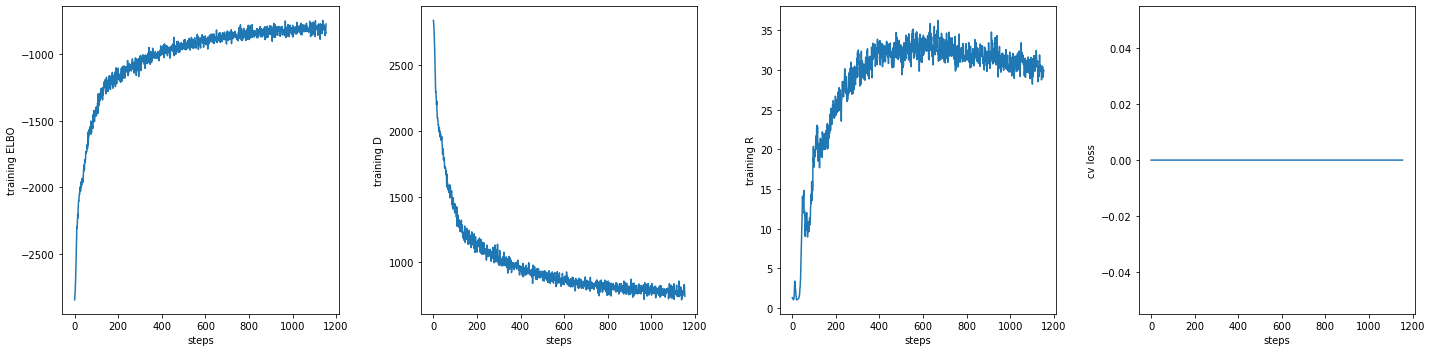

In [48]:
fig, axs = plt.subplots(1, 3 + int('training.cv_loss' in log), sharex=True, sharey=False, figsize=(20, 5))

_ = axs[0].plot(np.array(log['training.ELBO'])[:,0], np.array(log['training.ELBO'])[:,1])
_ = axs[0].set_ylabel("training ELBO")
_ = axs[0].set_xlabel("steps")

_ = axs[1].plot(np.array(log['training.D'])[:,0], np.array(log['training.D'])[:,1])
_ = axs[1].set_ylabel("training D")
_ = axs[1].set_xlabel("steps")

_ = axs[2].plot(np.array(log['training.R'])[:,0], np.array(log['training.R'])[:,1])
_ = axs[2].set_ylabel("training R")
_ = axs[2].set_xlabel("steps")

if 'training.cv_loss' in log:
    _ = axs[3].plot(np.array(log['training.cv_loss'])[:,0], np.array(log['training.cv_loss'])[:,1])
    _ = axs[3].set_ylabel("cv loss")
    _ = axs[3].set_xlabel("steps")

fig.tight_layout(h_pad=2, w_pad=2)

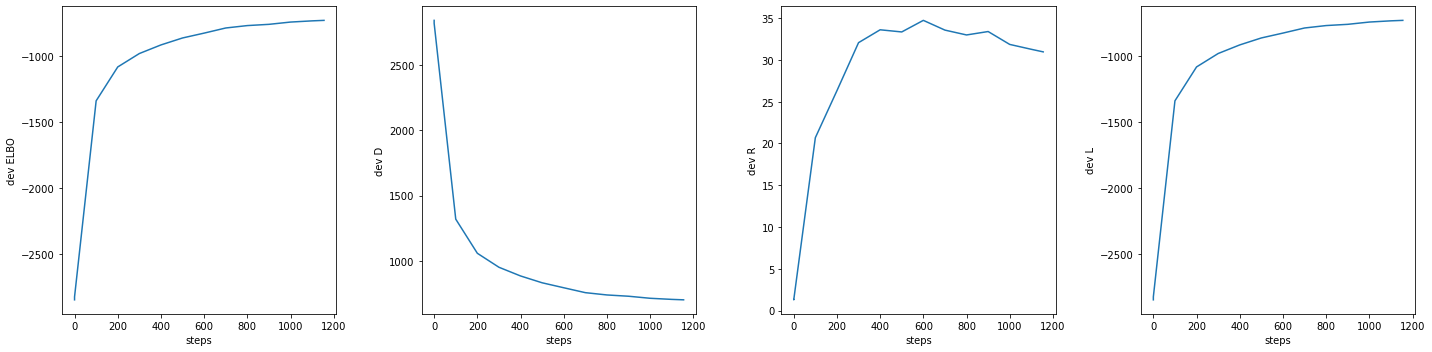

In [49]:
fig, axs = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(20, 5))

_ = axs[0].plot(np.array(log['dev.ELBO'])[:,0], np.array(log['dev.ELBO'])[:,1])
_ = axs[0].set_ylabel("dev ELBO")
_ = axs[0].set_xlabel("steps")

_ = axs[1].plot(np.array(log['dev.D'])[:,0], np.array(log['dev.D'])[:,1])
_ = axs[1].set_ylabel("dev D")
_ = axs[1].set_xlabel("steps")

_ = axs[2].plot(np.array(log['dev.R'])[:,0], np.array(log['dev.R'])[:,1])
_ = axs[2].set_ylabel("dev R")
_ = axs[2].set_xlabel("steps")

_ = axs[3].plot(np.array(log['dev.L'])[:,0], np.array(log['dev.L'])[:,1])
_ = axs[3].set_ylabel("dev L")
_ = axs[3].set_xlabel("steps")

fig.tight_layout(h_pad=2, w_pad=2)

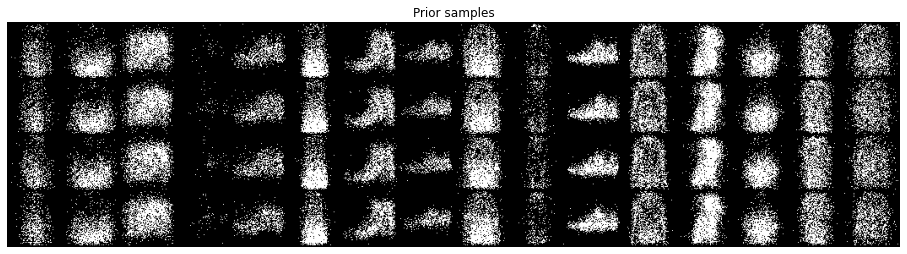

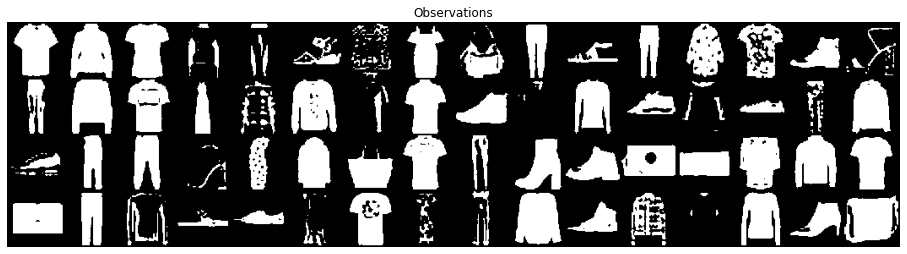

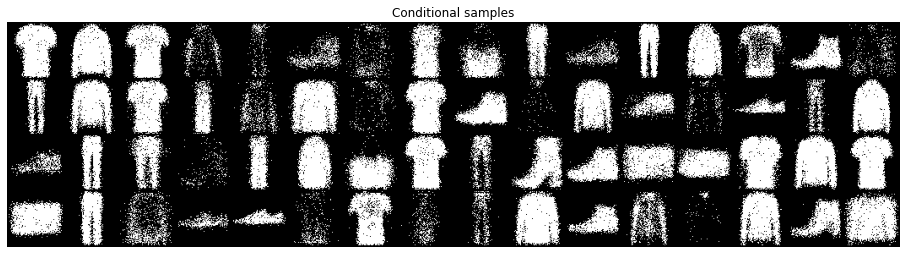

In [50]:
inspect_lvm(model, DataLoader(val_ds, 64, num_workers=2, pin_memory=True), my_device)

## 4. Beyond

There are various things you can try. 

You can try to use a **trainable prior**. If you do, you will probably note that it is not trivial how to get the prior to be used in an interesting way. In fact, trained priors are completely data-driven, and there's no reason to believe that an NN will find a "data-driven" explanation of the data that is anything like what you would like it to. If you want the different components of your prior to specialise to certain types of output, you will need to design stronger pressures. For example, you may use some degree of annotation to inform what each component should typically be responsible for. Ideas that dispense with the need for annotation will have to focus on the architecture of the decoder or on other penalties in the loss. For example, a decoder that is built with some geometric properties. 

If you use a trainable prior, it is a good idea to try and visualise what the final prior looks like. You can try sampling from it and plotting histograms of the different coordinates of the samples. You can flatten the samples and inspect the coordinates marginally, you can also use other plotting tools (see [some examples from seaborn](https://seaborn.pydata.org/examples/scatterplot_matrix.html)) to spot dependency, for example. And, of course, you can always use tools for dimensionality reduction (eg, [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)).

You can try to use a **stronger posterior approximation** that is  reparameterisable. A good idea is to build a bijective transformation (ie., a normalising flow). 

You can try to **improve the gradient estimator** of the mixture of mean field families. Within a mixture of C components that are each reparameterisable, only the component assigmment is a discrete operation, so with access to the sampling procedure internal to mixture, one can design a customised gradient estimator that updates $\omega(x; \lambda)$ through SFE, but updates $\mu(x; \lambda)$ and $\sigma(x;\lambda)$ through reparameterisation.
